In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/Clase_3/Tarea_1

/content/drive/MyDrive/Clase_3/Tarea_1


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.utils import plot_model, to_categorical

from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils import shuffle

In [4]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# take 10% as validation set
n_val = int(0.1*len(x_train))

x_val = x_train[:n_val]
x_train = x_train[n_val:]

y_val = y_train[:n_val]
y_train = y_train[n_val:]

print("Training: Data ({}), Labels ({})".format(x_train.shape, y_train.shape))
print("Validation: Data ({}), Labels ({})".format(x_val.shape, y_val.shape))
print("Testing: Data ({}), Labels ({})".format(x_test.shape, y_test.shape))

Training: Data ((54000, 28, 28)), Labels ((54000, 10))
Validation: Data ((6000, 28, 28)), Labels ((6000, 10))
Testing: Data ((10000, 28, 28)), Labels ((10000, 10))


In [5]:
# (#,28,28) => (#,28,28,1)
# uint8 => float
# [0,255] => [0,1]
x_train = np.expand_dims(x_train, axis=-1).astype("float32")/255.0
x_val = np.expand_dims(x_val, axis=-1).astype("float32")/255.0
x_test = np.expand_dims(x_test, axis=-1).astype("float32")/255.0

In [6]:
name_labels = ['T-shirt/top', 
               'Trouser', 
               'Pullover', 
               'Dress', 
               'Coat', 
               'Sandal', 
               'Shirt', 
               'Sneaker', 
               'Bag', 
               'Ankle boot']

n_classes = len(name_labels)

In [7]:
batch_size = 64
# Generador para Entrenamiento, con flips horizontal y vertical
gen_train = ImageDataGenerator(horizontal_flip=True,
                               vertical_flip=True)
# Generador para Validación
gen_val = ImageDataGenerator()

data_gen_train = gen_train.flow(x_train, y_train, batch_size=batch_size)
data_gen_val = gen_val.flow(x_val, y_val, batch_size=batch_size)

In [8]:
x_temp, y_tem = data_gen_train.next()
print(x_temp.shape, y_tem.shape)

(64, 28, 28, 1) (64, 10)


In [9]:
# Normalization before pooling
def get_model_norm_pool(filters, 
                        n_classes, 
                        k=3, 
                        name="my_model", 
                        padding="same", 
                        batch_norm=False, 
                        dropout=None):
    input_layer = Input(shape=(28,28,1))
    x = Conv2D(filters[0], (k,k), activation="relu", padding=padding)(input_layer)
    if batch_norm: x = BatchNormalization()(x)
    x = MaxPooling2D(2,2)(x)
    if dropout is not None: x = Dropout(dropout)(x)
    
    for n in filters[1:]:
        x = Conv2D(n, (k,k), activation="relu", padding=padding)(x)
        if batch_norm: x = BatchNormalization()(x)
        x = MaxPooling2D(2,2)(x)
        if dropout is not None: x = Dropout(dropout)(x)

    x = Flatten()(x)
    x = Dense(100, activation="relu")(x)
    output_layer = Dense(n_classes, activation="softmax")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer, name=name)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                  )
    return model

In [10]:
# Pooling before normalization
def get_model_pool_norm(filters, 
                        n_classes, 
                        k=3, 
                        name="my_model", 
                        padding="same", 
                        batch_norm=False, 
                        dropout=None):
    input_layer = Input(shape=(28,28,1))
    x = Conv2D(filters[0], (k,k), activation="relu", padding=padding)(input_layer)
    x = MaxPooling2D(2,2)(x)
    if batch_norm: x = BatchNormalization()(x)
    if dropout is not None: x = Dropout(dropout)(x)
    
    for n in filters[1:]:
        x = Conv2D(n, (k,k), activation="relu", padding=padding)(x)
        x = MaxPooling2D(2,2)(x)
        if batch_norm: x = BatchNormalization()(x)
        if dropout is not None: x = Dropout(dropout)(x)

    x = Flatten()(x)
    x = Dense(100, activation="relu")(x)
    output_layer = Dense(n_classes, activation="softmax")(x)
    
    model = Model(inputs=input_layer, outputs=output_layer, name=name)

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=['accuracy']
                  )
    return model

In [11]:
norm_bf_pool = get_model_norm_pool([16, 32], 
                                   n_classes, 
                                   name = "Norm_before_pooling", 
                                   batch_norm = True)

pool_bf_norm = get_model_pool_norm([16, 32], 
                                   n_classes, 
                                   name = "Pooling_before_norm", 
                                   batch_norm = True)

In [14]:
print("Model: {}, Parameters: {}".format(norm_bf_pool.name,
                                       norm_bf_pool.count_params()))

print("Model: {}, Parameters: {}".format(pool_bf_norm.name,
                                       pool_bf_norm.count_params()))


Model: Norm_before_pooling, Parameters: 162902
Model: Pooling_before_norm, Parameters: 162902


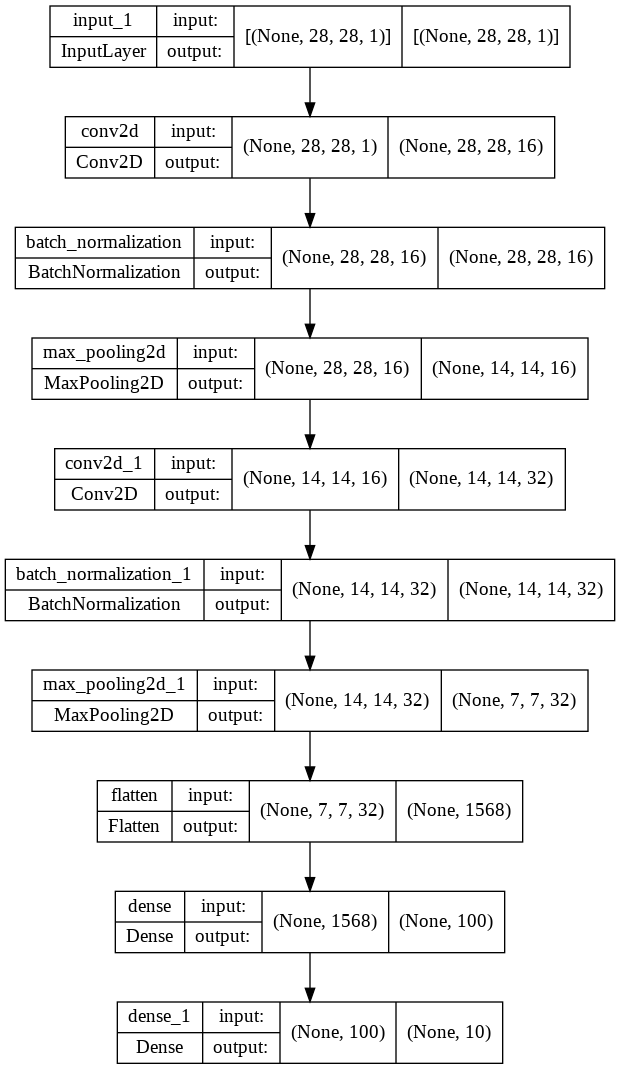

In [15]:
plot_model(norm_bf_pool, to_file="norm_bf_pool.png", show_shapes=True)

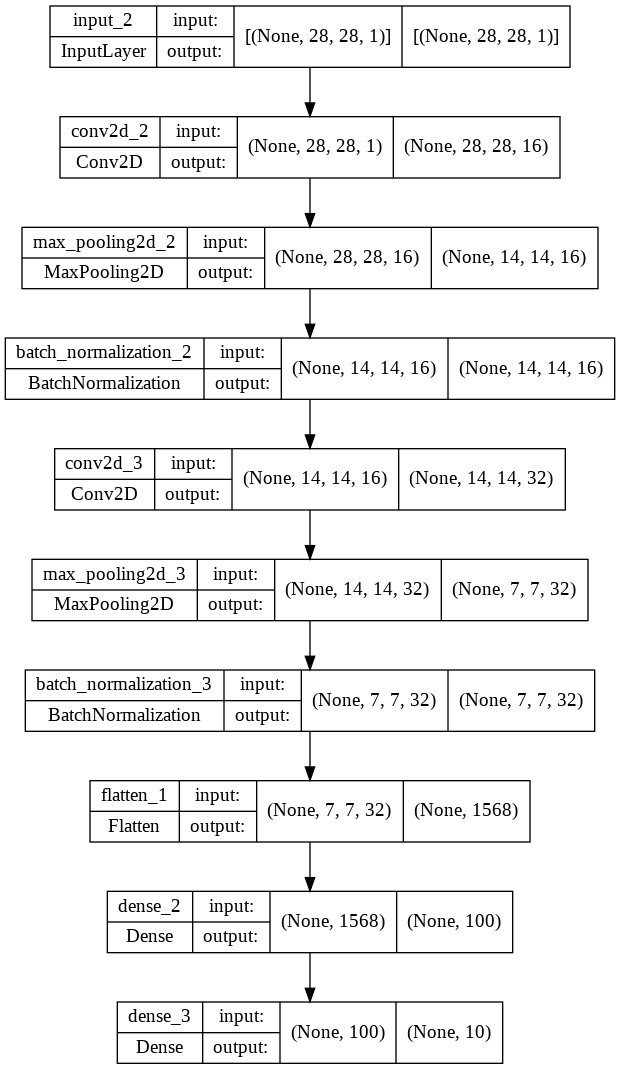

In [16]:
plot_model(pool_bf_norm, to_file="pool_bf_norm.png", show_shapes=True)